In [13]:
import numpy as np
import pandas as pd
from scipy.stats import kurtosis, skew
from numpy import convolve
import matplotlib.pyplot as plt
from scipy.interpolate import spline
import itertools
import math
from statistics import mode
from scipy.fftpack import *
from sklearn.tree import DecisionTreeClassifier
import scipy
import os
import csv
import pickle
from sklearn.externals import joblib
from __future__ import print_function
from scipy.signal import butter, lfilter, freqz

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn import svm

In [4]:
# Functions
def get_data(persons, if_present, sensors):
    global label
    temp_data = []
    suffix = '.csv'
    activities = ['sit', 'walk', 'lay', 'stand']
    
    
    temp_df = []
    all_data = []
    for per, person in enumerate(persons):
        act_data = []
        for act, activity in enumerate(activities):
            #print(activity)
            if( if_present[per][act] == 1):
                sens_data = []
                temp_df = []
                for sensor in sensors:
                    temp_df.append(pd.read_csv('results/' + person +'/' + sensor + '-' + activity + '.csv'))
                min_len = min([len(sensor_df) for sensor_df in temp_df])
                sens_data = temp_df[0].loc[:min_len-1,:]
                for sensor_df in temp_df[1:]:
                    sens_data = pd.concat([sens_data.loc[:, :sens_data.columns[-2]], sensor_df.loc[:min_len-1, :]], axis=1)

                act_data.append(sens_data)
                
        pers_data = act_data[0]
        
        for a_data in act_data[1:]:
            pers_data = pers_data.append(a_data)
            
        all_data.append(pers_data)    
    
    data = all_data[0]
    for a_data in all_data[1:]:
        data = data.append(a_data)
        
    
    columns = data.columns
    data.columns = [i if i== len(columns)-1 else columns[i] for i in range(len(columns))]
    label_col = len(data.columns) - 1
    
    train_data, test_data = train_test_split(data, test_size=0.2,shuffle=True)
    
    train_labels = train_data[label_col]
    train_data = train_data.drop(label_col, axis=1)
    
    test_labels = test_data[label_col]
    test_data = test_data.drop(label_col, axis=1)
    
    labels = data[label_col]
    data = data.drop(label_col, axis=1)
    
    train_labels = train_labels.astype('int')
    test_labels = test_labels.astype('int')
    labels = labels.astype('int')
    
    return data, labels, train_data, train_labels, test_data, test_labels

def readData(label,feature):
    suffix = '.csv'
    filename = os.path.join('data/csv/',label,feature+suffix)
    dataframe = pd.read_csv(filename,header=None)
    dataframe.columns = ['id','x','y','z','a','label']
    return dataframe

def stft(x, fftsize=256, overlap=2):   
    hop = fftsize // overlap
    w = scipy.hanning(fftsize+1)[:-1]
    return np.array([np.fft.fft(w*x[i:i+fftsize]) for i in range(0, len(x)-fftsize, hop)])

def get_fft(x):   
    return np.fft.fft(x)
    
def get_frequency(time):
    total_time = time[-1] - time[0]
    total_samples = len(time)
    frequency = (total_samples * 1000) // total_time
    return total_time, total_samples, frequency

def basicFeats(x, fftsize=256, overlap=2):
    meanamp = []
    maxamp = []
    minamp = []
    stdamp = []
    mad=[]
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        meanamp.append(np.array(np.mean(x[i:i+fftsize])))
        maxamp.append(np.array(np.max(x[i:i+fftsize])))
        minamp.append(np.array(np.min(x[i:i+fftsize])))
        stdamp.append(np.array(np.std(x[i:i+fftsize])))
        mad.append(np.array(np.median(np.abs(x[i:i+fftsize] - np.median(x[i:i+fftsize])))))
    return meanamp, maxamp, minamp, stdamp, mad

def feature(x, y, z, m, fftsize=256, overlap=2):
    energyamp_m = []
    kurtosisamp_m = []
    skewamp_m = []
    meanamp_x, maxamp_x, minamp_x, stdamp_x, mad_x = basicFeats(x, fftsize)
    meanamp_y, maxamp_y, minamp_y, stdamp_y, mad_y = basicFeats(y, fftsize)
    meanamp_z, maxamp_z, minamp_z, stdamp_z, mad_z = basicFeats(z, fftsize)
    meanamp_m, maxamp_m, minamp_m, stdamp_m, mad_m = basicFeats(m, fftsize)
    
    hop = fftsize // overlap
    for i in range(0, len(m)-fftsize, hop):
        energyamp_m.append(np.array(np.sum(np.power(m[i:i+fftsize],2))))
        kurtosisamp_m.append(kurtosis(m[i:i+fftsize]))
        skewamp_m.append(skew(m[i:i+fftsize]))
                
    return [meanamp_x, maxamp_x, minamp_x, stdamp_x, mad_x, meanamp_y, maxamp_y, minamp_y, stdamp_y, mad_y, 
            meanamp_z, maxamp_z, minamp_z, stdamp_z, mad_z, meanamp_m, maxamp_m, minamp_m, stdamp_m, mad_m, 
            energyamp_m, kurtosisamp_m, skewamp_m]

def normalize_fft_feat(features_list):
    ret_feat = []
    for feat in features_list:
        ret_feat.append(feat / np.linalg.norm(feat))
    
    return ret_feat
    
def normalize_feat(features_list):
    ret_feat = []
    for feat in features_list:
        ret_feat.append(feat / np.linalg.norm(feat))
    
    return ret_feat
            
def five_point_smoothing(m):
    m_smooth = np.zeros(len(m))
    m_smooth = m;
    for i ,val in enumerate(m_smooth[2 : (len(m_smooth) -2)]):
        m_smooth[i] = (m_smooth[i-2] + m_smooth[i-1] + m_smooth[i] + m_smooth[i+1] + m_smooth[i+2])/5
        
    return m_smooth

def inter_quartile_range(x, y, z, fftsize=256, overlap=2):
    """Calculates inter-quartile range"""
    iqr_x = []
    iqr_y = []
    iqr_z = []
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        iqr_x.append(np.subtract(*np.percentile(x[i:i+fftsize], [75, 25])))
        iqr_y.append(np.subtract(*np.percentile(y[i:i+fftsize], [75, 25])))
        iqr_z.append(np.subtract(*np.percentile(z[i:i+fftsize], [75, 25])))
    return iqr_x, iqr_y, iqr_z

def sma(x, y, z, fftsize=256, overlap=2):
    """Calculates signal magnitude area"""
    abs_x = []
    abs_y = []
    abs_z = []
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        abs_x.append(np.absolute(x[i:i+fftsize]))
        abs_y.append(np.absolute(y[i:i+fftsize]))
        abs_z.append(np.absolute(z[i:i+fftsize]))
    return [np.mean(x+y+z) for x,y,z in zip(abs_x, abs_y, abs_z)]

def calc_jerk(acc, ts):
    jk = [0]* len(acc)
    for i in range(1,len(acc)):
        jk[i-1] = 1000*(acc[i] - acc[i-1])/(ts[i] - ts[i-1])
    return jk

def get_jerk(x,fftsize=256, overlap=2):
    jerk_x=[]
    hop = fftsize // overlap
    for i in range(0, len(x)-fftsize, hop):
        jerk_x.append(np.array(np.mean(x[i:i+fftsize])))   
    
    return jerk_x

def get_window_label(labels, fftsize=256, overlap=2):
    hop = fftsize // overlap
    ret_labels = []
    for i in range(0, len(labels)-fftsize, hop):
        ret_labels.append(mode(labels[i:i+fftsize]))
    
    return ret_labels


In [10]:
#global dict
label = {'sitting' : 0, 'walking' : 1, 'laying_down' : 2, 'standing' : 3, 'unknown' : 4}


def compute_feats(*dataframes, show_plots=False):
    show_plots=False
    global label
    #df = pd.DataFrame(columns=list(range(60)))
    for counter, data in enumerate(dataframes):
        
        time, x, y, z, _, str_label = np.array(data[0]), np.array(data[1]), np.array(data[2]), np.array(data[3]), \
                                        np.array(data[4]), np.array(data[5])        
        
        total_time, total_sample, freq = get_frequency(time)
        #5 seconds time frame
        window_size = 5 * freq
        
        labels = [label[str_label[i]] for i in range(len(str_label))]
        window_labels = get_window_label(labels, fftsize=window_size)
        #Calculate the Frequency domain
        x = five_point_smoothing(x)
        y = five_point_smoothing(y)
        z = five_point_smoothing(z)
        
        ft_x = get_fft(x)
        ft_x = np.abs(ft_x)
        ft_y = get_fft(y)
        ft_y = np.abs(ft_y)
        ft_z = get_fft(z)
        ft_z = np.abs(ft_z)
        
        
        #Amplitude Calculation
        mpre = x * x + y * y + z * z
        m = np.sqrt(mpre)
        #Low pass filtering (5 point smoothing)
        if show_plots:
            plt.plot(m[:4000])
            plt.title('Accelerometer Data - '+str_label[0])
            plt.ylabel('Amplitude')
            plt.xlabel('Time')
            plt.show()
        
        #Jerk
        jerk_x = calc_jerk(x, time)
        jerk_y = calc_jerk(y, time)
        jerk_z = calc_jerk(z, time)
        jerk_m = np.array(jerk_x) * np.array(jerk_x) + np.array(jerk_y) * np.array(jerk_y) + np.array(jerk_z) * np.array(jerk_z)
        
        #FFT features
        stft_signal = stft(m, fftsize=window_size)
        energy_signal = []
        for i, amp in enumerate(stft_signal):
            energy_signal.append(np.sum(np.power(abs(stft_signal[i]),2)))
        
        features_list = feature(x, y, z, m, fftsize=window_size)
        features_list.append(energy_signal)
        diff_x = np.subtract(features_list[1], features_list[2])
        diff_y = np.subtract(features_list[6], features_list[7])
        diff_z = np.subtract(features_list[11], features_list[12])
        diff_m = np.subtract(features_list[16], features_list[17])
        features_list.append(diff_x)
        features_list.append(diff_y)
        features_list.append(diff_z)
        features_list.append(diff_m)
        
        iqr_x, iqr_y, iqr_z = inter_quartile_range(x, y, z, fftsize=window_size)
        smaq = sma(x, y, z, fftsize=window_size)
        features_list.append(iqr_x)
        features_list.append(iqr_y)
        features_list.append(iqr_z)
        features_list.append(smaq)
        
        #Add Jerk features to the list
        jerk_features_list = feature(jerk_x, jerk_y, jerk_z, jerk_m, fftsize=window_size)

        # Normalize other features
        norm_features_list = normalize_feat(features_list)
        norm_jerk_features_list = normalize_feat(jerk_features_list)
        
        ########################################################################
        # Frequency Domain
        ########################################################################
        
        #Frequency amplitude
        mpre = ft_x * ft_x + ft_y * ft_y + ft_z * ft_z
        m_f = np.sqrt(mpre)
        #Low pass filter (5 point Smoothing)
        
        if show_plots:
            plt.plot(m_f[:4000])
            plt.title('Accelerometer Data - '+str_label[0])
            plt.ylabel('Freq Amplitude')
            plt.xlabel('Time')
            plt.show()
        
        fft_features_list = feature(ft_x, ft_y, ft_z, m_f, fftsize=window_size)
        
        fft_diff_x = np.subtract(features_list[1], features_list[2])
        fft_diff_y = np.subtract(features_list[6], features_list[7])
        fft_diff_z = np.subtract(features_list[11], features_list[12])
        fft_diff_m = np.subtract(features_list[16], features_list[17])
        fft_features_list.append(fft_diff_x)
        fft_features_list.append(fft_diff_y)
        fft_features_list.append(fft_diff_z)
        fft_features_list.append(fft_diff_m)
        
        fft_iqr_x, fft_iqr_y, fft_iqr_z = inter_quartile_range(ft_x, ft_y, ft_z, fftsize=window_size)
        fft_smaq = sma(ft_x, ft_y, ft_z, fftsize=window_size)
        fft_features_list.append(fft_iqr_x)
        fft_features_list.append(fft_iqr_y)
        fft_features_list.append(fft_iqr_z)
        fft_features_list.append(fft_smaq)
        
        #Jerk
        win_jerk_x = get_jerk(jerk_x, fftsize=window_size)
        win_jerk_y = get_jerk(jerk_y, fftsize=window_size)
        win_jerk_z = get_jerk(jerk_z, fftsize=window_size)
        
        fft_jerk_x = get_fft(win_jerk_x)
        fft_jerk_x = np.abs(fft_jerk_x)        
        fft_jerk_y = get_fft(win_jerk_y)
        fft_jerk_y = np.abs(fft_jerk_y)
        fft_jerk_z = get_fft(win_jerk_z)
        fft_jerk_z = np.abs(fft_jerk_z)
        #Add Jerk features to the list
        fft_features_list.append(fft_jerk_x)
        fft_features_list.append(fft_jerk_y)
        fft_features_list.append(fft_jerk_z)
        jerk_iqr_x, jerk_iqr_y, jerk_iqr_z = inter_quartile_range(jerk_x, jerk_y, jerk_z, fftsize=window_size)
        jerk_smaq = sma(jerk_x, jerk_y, jerk_z, fftsize=window_size)
        
        #Normalize fft features
        fft_norm_features_list = normalize_fft_feat(fft_features_list)
        
        if show_plots:
            plt.plot(energy_signal[:4000])
            plt.xlabel('Freq')
            plt.ylabel('Energy')
            plt.title('Frequency vs Energy - '+str_label[0])
            plt.show()
        
        
        ####################################################################################
        norm_features_list.extend(fft_norm_features_list)
        norm_features_list.extend(norm_jerk_features_list)
        #Take transpose
        norm_features_list = list(map(list, zip(*norm_features_list)))
        
        #Put in a dataframe
        temp_df = pd.DataFrame(norm_features_list)
        temp_df[len(temp_df.columns)] = window_labels

        if counter == 0:
            df = temp_df
        else:
            df = df.append(temp_df)
            
    return df

In [33]:
#persons = ['ayush', 'shrey', 'varun']
persons = ['ayush', 'shrey']
activities = ['sit', 'walk', 'lay', 'stand']
sensors = ['accelerometer', 'gyroscope', 'magnetic']
#if_present = [[1,1,1,0], [1,0,1,1], [1,1,1,1]]
if_present = [[0,0,0,1], [0,1,0,0]]
nrows=300000
temp_df = []
for per, person in enumerate(persons):
    for act, activity in enumerate(activities):
        for sensor in sensors:
            if( if_present[per][act] == 1):
                print(person+" "+activity+" "+sensor)
                df =  pd.read_csv('Data/csv/' + person +'/' + sensor + '-' + activity + '.csv', header=None, nrows=nrows)
                df = compute_feats(df, show_plots=False)
                df.columns = [sensor[:3] + '_' + str(col) for col in df.columns]
                df.to_csv('results/' + person +'/' + sensor + '-'  + activity + '.csv', header=True, index=False)

ayush stand accelerometer
ayush stand gyroscope
ayush stand magnetic
shrey walk accelerometer
shrey walk gyroscope
shrey walk magnetic


In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Spectral):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig=plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)
    #plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "%.2f"%cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [35]:
###################################### Random Forest CLASSIFIER #####################################
def RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone',
                 search_best_params=False, load_model=True, sensor=''):
    if search_best_params:
        param_grid = { 
            'n_estimators': [200, 700],
            'max_features': ['auto', 'sqrt', 'log2']
        }
        CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
        CV_clf.fit(data, labels)
        print(CV_clf.best_params_)
        print('Most important Features are:', clf.feature_importances_, sep='')
    else:
        if load_model:
            clf = pickle.load(open('models/RFClassifier-' + use_model + '.pkl', 'rb'))
        else:
            if use_model == 'onevsone':
                clf = OneVsOneClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            else:
                clf = OneVsRestClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            clf.fit(train_data, train_labels)
            pickle.dump(clf, open('models/' + sensor + 'RFClassifier-' + use_model + '.pkl', 'wb'))
            saved_model = pickle.dumps(clf)
            joblib.dump(clf, 'azure_models1/' + sensor + 'RFClassifier-' + use_model + '.pkl')
            with open('azure_models/' + sensor + 'RFClassifier-' + use_model + '.pkl', 'wb') as f :
                f.write(saved_model)

    y_pred = clf.predict(test_data)
    print('-'*50)
    if use_model == 'onevsone':
        print('USING ONE VS ONE MODEL')
    else:
        print('USING ONE VS REST MODEL')
    print('Accuracy is:', accuracy_score(test_labels, y_pred))
    print('Classification Report:\n', classification_report(test_labels, y_pred, target_names=target_names))
    print('Confusion Matrix\n', confusion_matrix(test_labels, y_pred))
    plot_confusion_matrix(confusion_matrix(test_labels, y_pred),target_names)
    print('-'*50)
    return clf
    
###########################################################################################
###################################### SVM CLASSIFIER #####################################
###########################################################################################

def SVMClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone',
                  search_best_params=False, load_model=True, sensor=''):
    if search_best_params:
        clf = svm.SVC()
        parameters = {'kernel':('linear', 'rbf'), 'C':[0.1, 1, 10, 100]}
        clf = GridSearchCV(clf, parameters)
        clf.fit(data, labels) 
        print(clf.best_params_)
    else:
        if load_model:
            clf = pickle.load(open('models/SVMClassifier-' + use_model + '.pkl', 'rb'))
        else:
            if use_model == 'onevsone':
                clf = OneVsOneClassifier(svm.SVC(C=10, kernel='rbf'))

            else:
                clf = OneVsRestClassifier(svm.SVC(C=10, kernel='rbf'))
            
            clf.fit(train_data, train_labels)
            pickle.dump(clf, open('models/' + sensor + 'SVMClassifier-' + use_model + '.pkl', 'wb'))
            joblib.dump(clf, 'azure_models1/' + sensor + 'SVMClassifier-' + use_model + '.pkl')
            saved_model = pickle.dumps(clf)
            with open('azure_models/' + sensor + 'SVMClassifier-' + use_model + '.pkl', 'wb') as f :
                f.write(saved_model)


    y_pred = clf.predict(test_data)
    print('-'*50)
    if use_model == 'onevsone':
        print('USING ONE VS ONE MODEL')
    else:
        print('USING ONE VS REST MODEL')
    print('Accuracy is:', accuracy_score(test_labels, y_pred))
    print('Classification Report:\n', classification_report(test_labels, y_pred, target_names=target_names))
    print('Confusion Matrix\n', confusion_matrix(test_labels, y_pred))
    plot_confusion_matrix(confusion_matrix(test_labels, y_pred),target_names)
    print('-'*50)
    return clf

###########################################################################################
###################################### DT CLASSIFIER #####################################
###########################################################################################

def DTClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone',search_best_params=True, load_model=True):
    if search_best_params:
        clf = DecisionTreeClassifier(random_state=0)
        param_grid = { 
            'n_estimators': [200, 700],
            'max_features': ['auto', 'sqrt', 'log2']
        }
        CV_clf = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
        CV_clf.fit(data, labels)
        print(CV_clf.best_params_)
        print('Most important Features are:', clf.feature_importances_, sep='')
    else:
        if load_model:
            clf = pickle.load(open('models/RFClassifier-' + use_model + '.pkl', 'rb'))
        else:
            if use_model == 'onevsone':
                clf = OneVsOneClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            else:
                clf = OneVsRestClassifier(RandomForestClassifier(max_features= 'auto' ,n_estimators=200, oob_score = False))
            clf.fit(train_data, train_labels)
            pickle.dump(clf, open('models/RFClassifier-' + use_model + '.pkl', 'wb'))

    y_pred = clf.predict(test_data)
    print('-'*50)
    if use_model == 'onevsone':
        print('USING ONE VS ONE MODEL')
    else:
        print('USING ONE VS REST MODEL')
    print('Accuracy is:', accuracy_score(test_labels, y_pred))
    print('Classification Report:\n', classification_report(test_labels, y_pred, target_names=target_names))
    print('Confusion Matrix\n', confusion_matrix(test_labels, y_pred))
    plot_confusion_matrix(confusion_matrix(test_labels, y_pred),target_names)
    print('-'*50)
    return clf

--------------------------------------------------
USING ONE VS ONE MODEL
Accuracy is: 1.0
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      1.00      1.00       271
    walking       1.00      1.00      1.00       159
laying_down       1.00      1.00      1.00       257
   standing       1.00      1.00      1.00       212

avg / total       1.00      1.00      1.00       899

Confusion Matrix
 [[271   0   0   0]
 [  0 159   0   0]
 [  0   0 257   0]
 [  0   0   0 212]]


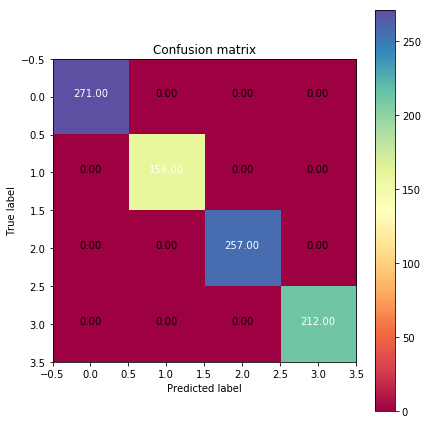

--------------------------------------------------
--------------------------------------------------
USING ONE VS REST MODEL
Accuracy is: 1.0
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      1.00      1.00       271
    walking       1.00      1.00      1.00       159
laying_down       1.00      1.00      1.00       257
   standing       1.00      1.00      1.00       212

avg / total       1.00      1.00      1.00       899

Confusion Matrix
 [[271   0   0   0]
 [  0 159   0   0]
 [  0   0 257   0]
 [  0   0   0 212]]


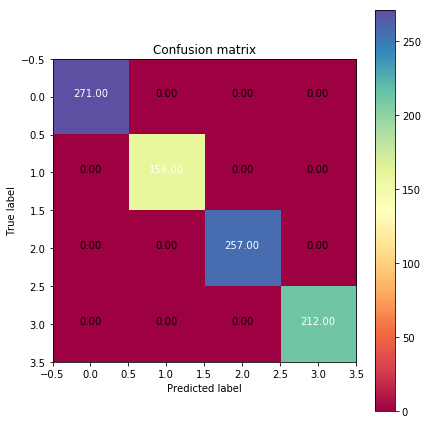

--------------------------------------------------
--------------------------------------------------
USING ONE VS ONE MODEL
Accuracy is: 0.9977827051
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      0.99      1.00       246
    walking       1.00      1.00      1.00       177
laying_down       1.00      1.00      1.00       253
   standing       0.99      1.00      1.00       226

avg / total       1.00      1.00      1.00       902

Confusion Matrix
 [[244   0   0   2]
 [  0 177   0   0]
 [  0   0 253   0]
 [  0   0   0 226]]


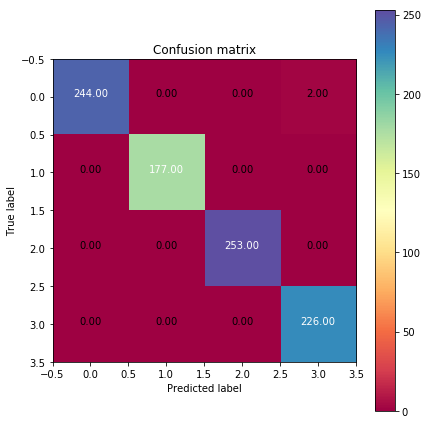

--------------------------------------------------
--------------------------------------------------
USING ONE VS REST MODEL
Accuracy is: 0.99667405765
Classification Report:
              precision    recall  f1-score   support

    sitting       1.00      0.99      0.99       246
    walking       1.00      1.00      1.00       177
laying_down       1.00      1.00      1.00       253
   standing       0.99      1.00      1.00       226

avg / total       1.00      1.00      1.00       902

Confusion Matrix
 [[244   0   0   2]
 [  0 177   0   0]
 [  1   0 252   0]
 [  0   0   0 226]]


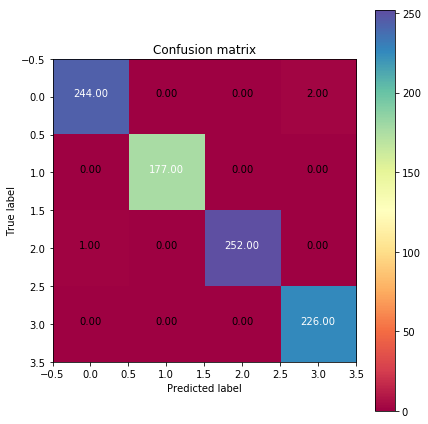

--------------------------------------------------


OneVsRestClassifier(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          n_jobs=1)

In [37]:
############## Random Forest Classifier ##############
search_best_params = False
load_model = True
persons = ['ayush', 'shrey', 'varun']
if_present = [[1,1,1,1], [1,1,1,1], [1,1,1,1]]
sensors = ['accelerometer', 'gyroscope', 'magnetic']
target_names = ['sitting', 'walking','laying_down','standing']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons, if_present, sensors)
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', search_best_params=False, load_model=load_model)
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', search_best_params=False, load_model=load_model)

# For Acceleration only
sensors = ['accelerometer']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons, if_present, sensors)
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', 
             search_best_params=False, load_model=load_model, sensor='acc_')
RFClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', 
             search_best_params=False, load_model=load_model, sensor='acc_')

--------------------------------------------------
USING ONE VS ONE MODEL
Accuracy is: 0.620689655172
Classification Report:
              precision    recall  f1-score   support

    sitting       0.65      0.68      0.66       259
    walking       0.78      0.81      0.80       151
laying_down       0.52      0.71      0.60       262
   standing       0.66      0.32      0.43       227

avg / total       0.64      0.62      0.61       899

Confusion Matrix
 [[175  10  67   7]
 [  2 123   5  21]
 [ 58   8 187   9]
 [ 36  17 101  73]]


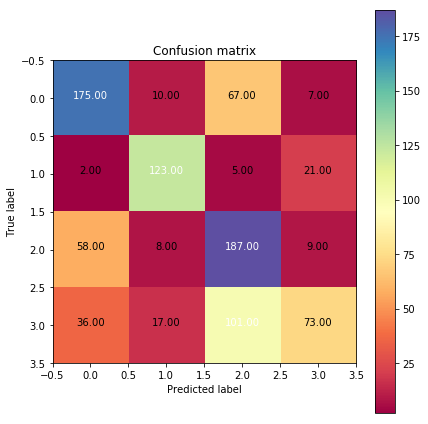

--------------------------------------------------
--------------------------------------------------
USING ONE VS REST MODEL
Accuracy is: 0.699666295884
Classification Report:
              precision    recall  f1-score   support

    sitting       0.61      0.92      0.73       259
    walking       0.68      0.97      0.80       151
laying_down       0.79      0.63      0.70       262
   standing       0.90      0.35      0.51       227

avg / total       0.75      0.70      0.68       899

Confusion Matrix
 [[237   6  15   1]
 [  0 147   0   4]
 [ 85   8 165   4]
 [ 64  54  29  80]]


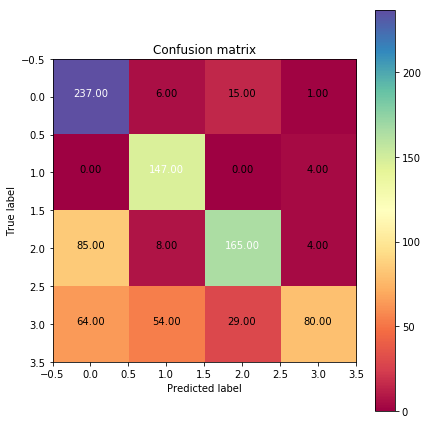

--------------------------------------------------
--------------------------------------------------
USING ONE VS ONE MODEL
Accuracy is: 0.615299334812
Classification Report:
              precision    recall  f1-score   support

    sitting       0.52      0.88      0.65       273
    walking       0.82      0.87      0.84       167
laying_down       0.72      0.43      0.53       263
   standing       0.56      0.29      0.38       199

avg / total       0.64      0.62      0.59       902

Confusion Matrix
 [[240   5   9  19]
 [  8 146   3  10]
 [127   9 112  15]
 [ 91  19  32  57]]


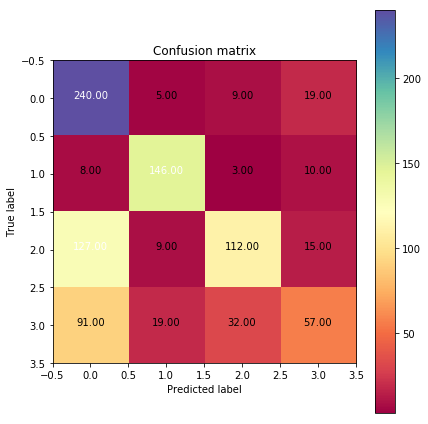

--------------------------------------------------
--------------------------------------------------
USING ONE VS REST MODEL
Accuracy is: 0.70288248337
Classification Report:
              precision    recall  f1-score   support

    sitting       0.66      0.89      0.76       273
    walking       0.69      0.94      0.80       167
laying_down       0.75      0.69      0.72       263
   standing       0.84      0.26      0.40       199

avg / total       0.73      0.70      0.67       902

Confusion Matrix
 [[244   5  24   0]
 [  6 157   1   3]
 [ 66   9 181   7]
 [ 55  56  36  52]]


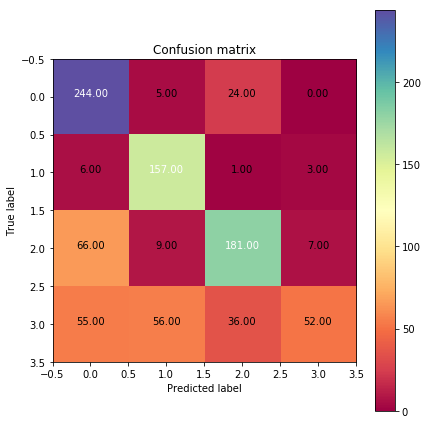

--------------------------------------------------


OneVsRestClassifier(estimator=SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

In [39]:
############## SVM ##############
search_best_params = False
load_model = False
persons = ['ayush', 'shrey', 'varun']
if_present = [[1,1,1,1], [1,1,1,1], [1,1,1,1]]
sensors = ['accelerometer', 'gyroscope', 'magnetic']
target_names = ['sitting', 'walking','laying_down','standing']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons, if_present, sensors)
SVMClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', search_best_params=False, load_model=load_model)
SVMClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', search_best_params=False, load_model=load_model)

# For Acceleration only
sensors = ['accelerometer']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons, if_present, sensors)
SVMClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', 
             search_best_params=False, load_model=load_model, sensor='acc_')
SVMClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', 
             search_best_params=False, load_model=load_model, sensor='acc_')

In [12]:
############## Decision Tree Classifier ##############
search_best_params = True
load_model = False
persons = ['ayush', 'shrey', 'varun']
#sensors = ['accelerometer', 'gyroscope', 'magnetic']
sensors = ['accelerometer']
target_names = ['sitting', 'walking','laying_down','standing']
data, labels, train_data, train_labels, test_data, test_labels = get_data(persons)
DTClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsone', search_best_params=search_best_params, load_model=load_model)
DTClassifier(data, labels, train_data, train_labels, test_data, test_labels, use_model='onevsrest', search_best_params=search_best_params, load_model=load_model)

TypeError: get_data() missing 2 required positional arguments: 'if_present' and 'sensors'

# TEST ON ANOTHER PERSON

In [40]:
# Testing Function
def test_model(files, sensor):
    string_annot = ['acc_', 'gyr_', 'mag_']
    dfs = []
    for i, file in enumerate(files):
        file = compute_feats(file, show_plots=False)
        file.columns = [string_annot[i] + str(col) for col in file.columns]
        dfs.append(file)

    min_len = min([len(df) for df in dfs])
    final_df = dfs[0]
    for df in dfs[1:]:
        final_df = pd.concat([final_df.loc[:min_len-1, :final_df.columns[-2]], 
                              df.loc[:min_len-1, :]], axis=1)
        
    final_df.columns = [i if i == len(final_df.columns)-1 else final_df.columns[i] for i in range(len(final_df.columns))]
    label_col = len(final_df.columns) - 1
    labels = final_df[label_col]
    labels = labels.astype('int')
    data = final_df.drop(label_col, axis=1)    
    use_models = [sensor+'RFClassifier-onevsone', sensor+'RFClassifier-onevsrest', 
                  sensor+'SVMClassifier-onevsone', sensor+'SVMClassifier-onevsrest']
    target_names = ['sitting', 'walking','laying_down','standing']

    for use_model in use_models:
        clf = joblib.load('azure_models1/' + use_model + '.pkl')
        y_pred = clf.predict(data)
        print('-'*50)
        print('USING %s MODEL' %use_model)
        print('Accuracy is:', accuracy_score(labels, y_pred))
        print(labels, y_pred)
        print('Classification Report:\n', classification_report(labels, y_pred,target_names=target_names))
        print('Confusion Matrix\n', confusion_matrix(labels, y_pred))
        plot_confusion_matrix(confusion_matrix(labels, y_pred), target_names)
        print('-'*50)
        
        
def test_model_api(files):
    ''' This function is for API call made by Azure '''
    
    string_annot = ['acc_', 'gyr_', 'mag_']
    dfs = []
    for i, file in enumerate(files):
        file = compute_feats(file, show_plots=False)
        file.columns = [string_annot[i] + str(col) for col in file.columns]
        dfs.append(file)

    min_len = min([len(df) for df in dfs])
    final_df = dfs[0]
    for df in dfs[1:]:
        final_df = pd.concat([final_df.loc[:min_len-1, :final_df.columns[-2]], 
                              df.loc[:min_len-1, :]], axis=1)
        
    final_df.columns = [i if i == len(final_df.columns)-1 else final_df.columns[i] for i in range(len(final_df.columns))]
    label_col = len(final_df.columns) - 1
    labels = final_df[label_col]
    labels = labels.astype('int')
    data = final_df.drop(label_col, axis=1)
    return data

FOR LAYING
--------------------------------------------------
JUST WITH ACCELEROMETER DATA
--------------------------------------------------
USING acc_RFClassifier-onevsone MODEL
Accuracy is: 0.0
0    2
1    2
2    2
3    2
4    2
5    2
6    2
Name: 89, dtype: int32 [3 3 3 3 0 3 1]
Classification Report:
              precision    recall  f1-score   support

    sitting       0.00      0.00      0.00         0
    walking       0.00      0.00      0.00         0
laying_down       0.00      0.00      0.00         7
   standing       0.00      0.00      0.00         0

avg / total       0.00      0.00      0.00         7

Confusion Matrix
 [[0 0 0 0]
 [0 0 0 0]
 [1 1 0 5]
 [0 0 0 0]]


C:\Users\Raghu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Raghu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


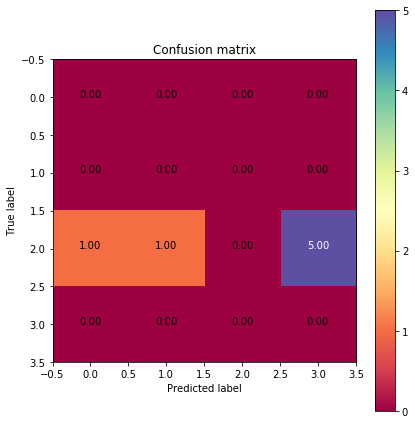

--------------------------------------------------
--------------------------------------------------
USING acc_RFClassifier-onevsrest MODEL
Accuracy is: 0.714285714286
0    2
1    2
2    2
3    2
4    2
5    2
6    2
Name: 89, dtype: int32 [2 2 2 2 2 1 1]
Classification Report:
              precision    recall  f1-score   support

    sitting       0.00      0.00      0.00         0
    walking       1.00      0.71      0.83         7

avg / total       1.00      0.71      0.83         7

Confusion Matrix
 [[0 0]
 [2 5]]


C:\Users\Raghu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 2, does not match size of target_names, 4
  .format(len(labels), len(target_names))


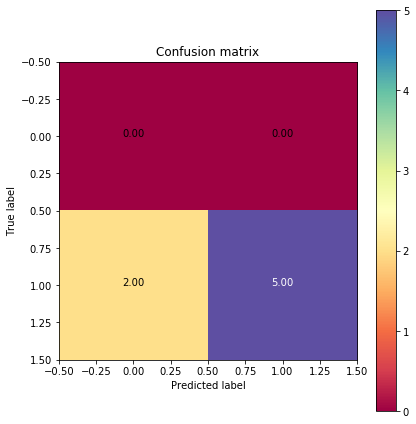

--------------------------------------------------
--------------------------------------------------
USING acc_SVMClassifier-onevsone MODEL
Accuracy is: 0.285714285714
0    2
1    2
2    2
3    2
4    2
5    2
6    2
Name: 89, dtype: int32 [0 2 2 3 1 1 1]
Classification Report:
              precision    recall  f1-score   support

    sitting       0.00      0.00      0.00         0
    walking       0.00      0.00      0.00         0
laying_down       1.00      0.29      0.44         7
   standing       0.00      0.00      0.00         0

avg / total       1.00      0.29      0.44         7

Confusion Matrix
 [[0 0 0 0]
 [0 0 0 0]
 [1 3 2 1]
 [0 0 0 0]]


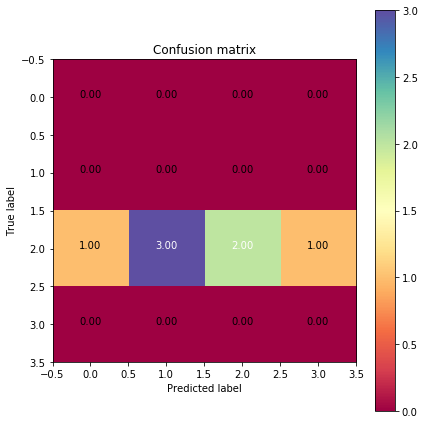

--------------------------------------------------
--------------------------------------------------
USING acc_SVMClassifier-onevsrest MODEL
Accuracy is: 0.428571428571
0    2
1    2
2    2
3    2
4    2
5    2
6    2
Name: 89, dtype: int32 [0 2 2 2 1 1 1]
Classification Report:
              precision    recall  f1-score   support

    sitting       0.00      0.00      0.00         0
    walking       0.00      0.00      0.00         0
laying_down       1.00      0.43      0.60         7

avg / total       1.00      0.43      0.60         7

Confusion Matrix
 [[0 0 0]
 [0 0 0]
 [1 3 3]]


C:\Users\Raghu\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1428: UserWarning: labels size, 3, does not match size of target_names, 4
  .format(len(labels), len(target_names))


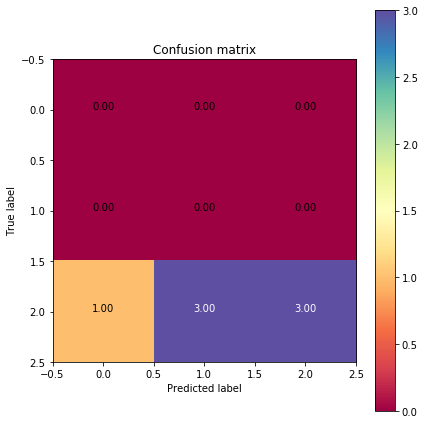

--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
WITH ALL 3 SENSORS DATA
--------------------------------------------------
USING RFClassifier-onevsone MODEL
Accuracy is: 0.428571428571
0    2
1    2
2    2
3    2
4    2
5    2
6    2
Name: 267, dtype: int32 [0 3 3 3 2 2 2]
Classification Report:
              precision    recall  f1-score   support

    sitting       0.00      0.00      0.00         0
    walking       1.00      0.43      0.60         7
laying_down       0.00      0.00      0.00         0

avg / total       1.00      0.43      0.60         7

Confusion Matrix
 [[0 0 0]
 [1 3 3]
 [0 0 0]]


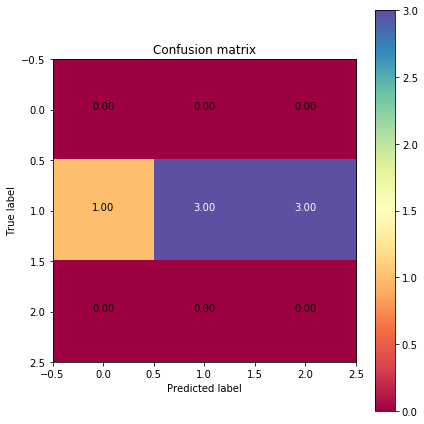

--------------------------------------------------
--------------------------------------------------
USING RFClassifier-onevsrest MODEL
Accuracy is: 0.285714285714
0    2
1    2
2    2
3    2
4    2
5    2
6    2
Name: 267, dtype: int32 [3 2 2 3 1 1 1]
Classification Report:
              precision    recall  f1-score   support

    sitting       0.00      0.00      0.00         0
    walking       1.00      0.29      0.44         7
laying_down       0.00      0.00      0.00         0

avg / total       1.00      0.29      0.44         7

Confusion Matrix
 [[0 0 0]
 [3 2 2]
 [0 0 0]]


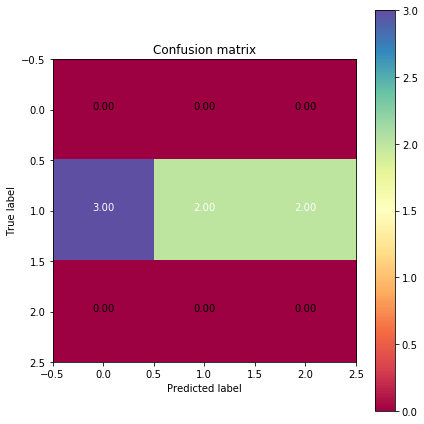

--------------------------------------------------
--------------------------------------------------
USING SVMClassifier-onevsone MODEL
Accuracy is: 0.142857142857
0    2
1    2
2    2
3    2
4    2
5    2
6    2
Name: 267, dtype: int32 [2 0 0 0 1 1 1]
Classification Report:
              precision    recall  f1-score   support

    sitting       0.00      0.00      0.00         0
    walking       0.00      0.00      0.00         0
laying_down       1.00      0.14      0.25         7

avg / total       1.00      0.14      0.25         7

Confusion Matrix
 [[0 0 0]
 [0 0 0]
 [3 3 1]]


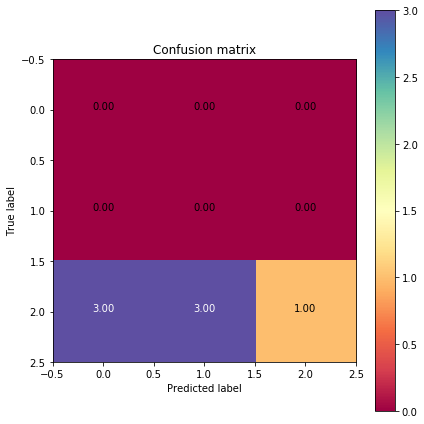

--------------------------------------------------
--------------------------------------------------
USING SVMClassifier-onevsrest MODEL
Accuracy is: 0.285714285714
0    2
1    2
2    2
3    2
4    2
5    2
6    2
Name: 267, dtype: int32 [0 0 2 2 1 1 1]
Classification Report:
              precision    recall  f1-score   support

    sitting       0.00      0.00      0.00         0
    walking       0.00      0.00      0.00         0
laying_down       1.00      0.29      0.44         7

avg / total       1.00      0.29      0.44         7

Confusion Matrix
 [[0 0 0]
 [0 0 0]
 [2 3 2]]


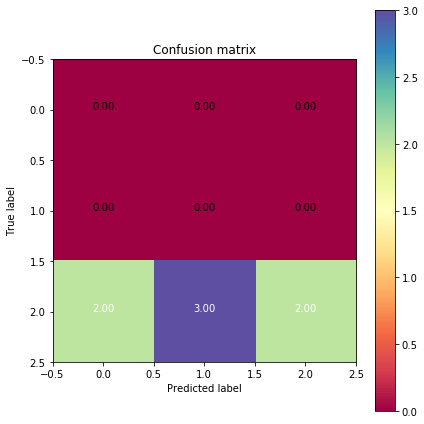

--------------------------------------------------


In [42]:
df_acc = pd.read_csv('data/csv/ashish/accelerometer-lay.csv', header=None, nrows=5000)
df_gyro = pd.read_csv('data/csv/ashish/gyroscope-lay.csv', header=None, nrows=5000)
df_mag = pd.read_csv('data/csv/ashish/magnetic-lay.csv', header=None, nrows=5000)

sit_df_acc = pd.read_csv('data/csv/ashish/accelerometer-sit.csv', header=None, nrows=5000)
sit_df_gyro = pd.read_csv('data/csv/ashish/gyroscope-sit.csv', header=None, nrows=5000)
sit_df_mag = pd.read_csv('data/csv/ashish/magnetic-sit.csv', header=None, nrows=5000)

# print('-'*50)
# print('JUST WITH ACCELEROMETER DATA')
# test_model([sit_df_acc], 'acc_')

# print('-'*50)
# print('WITH ALL 3 SENSORS DATA')
# test_model([sit_df_acc, sit_df_gyro, sit_df_mag], '')

print('FOR LAYING')
print('-'*50)
print('JUST WITH ACCELEROMETER DATA')
test_model([df_acc], 'acc_')

print('-'*50)
print('-'*50)
print('WITH ALL 3 SENSORS DATA')
test_model([df_acc, df_gyro, df_mag], '')



In [14]:
df[138].value_counts().plot(kind='bar', title='Training examples by activity type')
plt.show()

KeyError: 138

In [16]:
def plot_activity(activity, df):
    data = df[df[22] == activity][[1, 2, 3]][:200]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
plot_activity(0, df)
plt.show()
plot_activity(1, df)
plt.show()
plot_activity("standing", df)
plt.show()
plot_activity("laying_down", df)
plt.show()

KeyError: 22